In [30]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
import pymorphy2
from pymystem3 import Mystem
import seaborn as sns
import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\223hy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
df = pd.read_excel('C:\\Users\\223hy\\OneDrive\\Рабочий стол\\matcher\\sku_matcher\\500rows.xlsx')

In [32]:
df['ITEM'] = df['ITEM'].astype(str)
df['DESC'] = df['DESC'].astype(str)
df = df.dropna()

In [33]:
# очистка текста в колонке 'ITEM'
def clean_text(text):
    # удаление лишних символов и приведение к нижнему регистру
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    
    # токенизация
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    
    # удаление стоп-слов
    stop_words = set(stopwords.words('english') + stopwords.words('russian'))
    tokens = [token for token in tokens if not token in stop_words]
    
    # исключения для стемминга
    stemming_exceptions = {'sony'}
    
    # стемминг
    stemmer = SnowballStemmer('english')
    tokens = [stemmer.stem(token) if token not in stemming_exceptions else token for token in tokens]
    
    # объединение токенов в строку
    text = ' '.join(tokens)
    return text

# применение функции очистки текста к колонке 'DESC'
df['DESC'] = df['DESC'].apply(clean_text)

In [34]:
morph = pymorphy2.MorphAnalyzer()

def lemmatize_text(text):
    tokens = text.split()
    lemmas = [morph.parse(token)[0].normal_form for token in tokens]
    return ' '.join(lemmas)

# применение функции лемматизации к русским словам в колонке 'DESC'
df['DESC'] = df['DESC'].apply(lemmatize_text)


In [35]:
df

,ITEM,DESC
0,PS719709992,игровой приставка sony playstat 5 825 гб ssd б...
1,PS719398707,игровой консоль sony playstat 5 825gb
2,PS719398707,sony playstat 5 cfi1008a
3,PS719709992,sony playstat 5 cfi1108a
4,PS719398707,6301853 игровой приставка sony playstat 5 диск...
...,...,...
545,PS719709992,ps719709992 dualsenc ps5
546,PS719709992,ps719709992 dualsens white ps5
547,PS719398707,ps719709992 eiger black consolerusind
548,PS719709992,ps719709992 ps5 white


In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Создаем объект TfidfVectorizer и обучаем его на текстах из колонки DESC
tfidf_vectorizer = TfidfVectorizer()
item_tfidf = tfidf_vectorizer.fit_transform(df['DESC'])

# Проверяем размерность матрицы
print(item_tfidf.shape)


(550, 385)


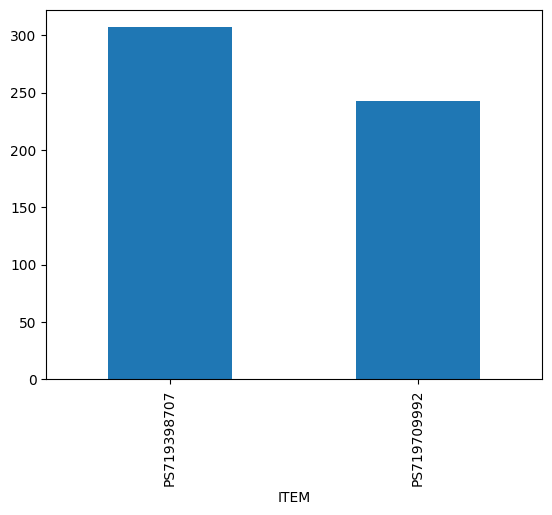

In [37]:
import matplotlib.pyplot as plt

df['ITEM'].value_counts().plot(kind='bar')
plt.show()


Будем использовать матрицу item_tfidf как матрицу признаков X, а столбец MATERIAL SAP исходного датафрейма как целевую переменную y

In [38]:
from sklearn.model_selection import train_test_split

# Выделяем целевую переменную
y = df['ITEM']

# Проверяем размерности матрицы признаков и целевой переменной
assert item_tfidf.shape[0] == len(y)

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(item_tfidf, y, test_size=0.2, random_state=42)


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Разбиваем на train и test
X_train, X_test, y_train, y_test = train_test_split(item_tfidf, y, test_size=0.2, random_state=42)

# Обучаем логистическую регрессию
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train, y_train)

# Предсказываем значения на тестовой выборке
y_pred = logreg.predict(X_test)

# Оцениваем качество модели на тестовой выборке
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.8090909090909091


In [40]:
from sklearn.tree import DecisionTreeClassifier

# Обучаем решающее дерево
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Предсказываем значения на тестовой выборке
y_pred = clf.predict(X_test)

# Оцениваем качество модели на тестовой выборке
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.8727272727272727


In [41]:
test_df = pd.read_excel('C:\\Users\\223hy\\OneDrive\\Рабочий стол\\matcher\\sku_matcher\\test_df.xlsx')
test_df

,DESC
0,Гарнитура Sony PS5 Pulse 3D Wireless Headset B...
1,Пульт Media Remote для Sony PS5
2,HD Camera для Sony PS5
3,Игровая консоль Sony PlayStation Digital Editi...
4,Игровая консоль Sony PlayStation 5 Ultra HD Bl...
...,...
535,HD Camera для Sony PS5
536,Игровая консоль Sony PlayStation 5 Ultra HD Bl...
537,Гарнитура Sony PS5 Pulse 3D Wireless Headset
538,Гарнитура Sony PS5 Pulse 3D Wireless Headset B...


In [42]:
# применение функции очистки текста к колонке 'DESC'
test_df['DESC'] = test_df['DESC'].apply(clean_text)

# применение функции лемматизации к русским словам в колонке 'DESC'
test_df['DESC'] = test_df['DESC'].apply(lemmatize_text)
test_df

,DESC
0,гарнитур sony ps5 puls 3d wireless headset bla...
1,пульт media remot sony ps5
2,hd camera sony ps5
3,игровой консоль sony playstat digit edit god w...
4,игровой консоль sony playstat 5 ultra hd blura...
...,...
535,hd camera sony ps5
536,игровой консоль sony playstat 5 ultra hd blura...
537,гарнитур sony ps5 puls 3d wireless headset
538,гарнитур sony ps5 puls 3d wireless headset bla...


In [43]:
# Векторизуем текст в колонке DESC в test_df
test_item_tfidf = tfidf_vectorizer.transform(test_df['DESC'].astype(str))

# Применяем обученную модель к test_item_tfidf и получаем вероятности для каждой метки класса
predicted_prob = clf.predict_proba(test_item_tfidf)

# Выбираем только те значения, для которых вероятность превышает порог
predicted_labels = [clf.classes_[np.argmax(pred)] if np.max(pred) > 0.9 else None for pred in predicted_prob]

# Записываем соответствующие значения MATERIAL SAP в новый столбец
test_df['PREDICTED_ITEM'] = predicted_labels


ручная валидация ошибок на тестовых данных
деревья решений
каскад из моделей (каждая модель работает с ошибками предыдущей)

In [44]:
predicted_starts_with_PS7 = test_df[test_df['PREDICTED_ITEM'].str.startswith('PS7', na=False)]
print(predicted_starts_with_PS7)

                                                  DESC PREDICTED_ITEM
0    гарнитур sony ps5 puls 3d wireless headset bla...    PS719398707
1                           пульт media remot sony ps5    PS719398707
2                                   hd camera sony ps5    PS719398707
3    игровой консоль sony playstat digit edit god w...    PS719398707
4    игровой консоль sony playstat 5 ultra hd blura...    PS719398707
..                                                 ...            ...
535                                 hd camera sony ps5    PS719398707
536  игровой консоль sony playstat 5 ultra hd blura...    PS719398707
537         гарнитур sony ps5 puls 3d wireless headset    PS719398707
538  гарнитур sony ps5 puls 3d wireless headset bla...    PS719398707
539  игровой консоль sony playstat digit edit god w...    PS719398707

[540 rows x 2 columns]
